#### `FLAX: A Neural Network Library for JAX`

Flax is a neural network library for JAX that is designed to be flexible, efficient, and easy to use. 

It provides a high-level API for building and training neural networks, as well as a low-level API for implementing custom layers and optimizers.

Flax now has support for 2 APIs:
-   [Flax Linen](https://flax-linen.readthedocs.io/en/latest/) (`flax.linen`): A high-level API for building neural networks. It is designed to be easy to use and to support a wide range of neural network architectures. Linen is built on top of JAX's functional programming primitives, which makes it easy to write efficient and scalable code. 

    Flax linen uses lazy evaluation to build neural networks and is bit complex to use cmp to `Flax.nnx`

<hr/>

- [Flax NNX](https://flax.readthedocs.io/en/latest/index.html) (`flax.nnx`): A simplified API that makes it easier to create, inspect, debug, and analyze neural networks in JAX. Flax NNX has first class support for Python reference semantics, enabling users to express their models using regular Python objects. Flax NNX is an evolution of the previous Flax Linen.

    Flax NNX is a bit easier to use than Flax Linen. It is designed to be a simple and intuitive API for building neural networks. It is pythonic and easy to use.

In [1]:
import jax
import jax.numpy as jnp
import flax
from flax import linen as nn

In [2]:
# Every Module in Flax is a subclass of nn.Module
# A Module in linen is a dataclass
class MyModule(nn.Module):
    # define parameters such as hidden-size,activation,etc
    def setup(self):
        # initalize model here
        pass

    def __call__(self,x):
        # forward pass here
        pass

# ==================== or =======================

class MyModuleCompact(nn.Module):
    # define parameters such as hidden-size,activation,etc
    @nn.compact
    def __call__(self,x):
        # nn.compact takes care of initializing parameters
        # forward pass here
        pass

### `Param & Variable in Flax`
In Flax, the concepts of parameters (params) and variables are central to defining and managing the state of neural networks.

👉🏻 _Parameters (params)_
Parameters in Flax are the trainable weights and biases of a neural network. They are typically defined within the setup method of a Flax module and are used to compute the outputs of the network. Parameters are stored in a nested dictionary structure.

👉🏻 _Variables_
Variables in Flax can include parameters, but they can also include other types of state, such as batch statistics for batch normalization or running averages for momentum. Variables are more general and can be used to store any kind of state that the model needs to maintain.These hold other mutable state that's not directly optimized (e.g., batch statistics for BatchNorm, non-trainable embeddings, or other internal state). They can be updated using explicit assign operations within the @flax.struct.dataclass that holds them.

<hr/>

__When to Use What?__

Parameters (params):

Use parameters for trainable weights and biases.
These are the primary components that are optimized during training.
Example: Weights and biases in dense layers.
Variables:

Variables:

Use variables for any state that the model needs to maintain.
This can include parameters, but also other types of state like batch statistics.
Example: Batch statistics in batch normalization layers.



In [187]:
import flax.linen as nn
import jax
import jax.numpy as jnp

# Custom layer with its own parameters
class MyCustomLayer(nn.Module):
    features: int  # Number of output features
    @nn.compact
    def __call__(self, x):
        # Initialize parameters (kernel and bias) using `self.param`
        kernel = self.param('kernel', nn.initializers.lecun_normal(), 
                            (x.shape[-1], self.features))
        bias = self.param('bias', nn.initializers.zeros, (self.features,))
        return jnp.dot(x, kernel) + bias


# Example of a module using variables for mutable state (e.g., a running average)
class MyModuleWithState(nn.Module):
    @nn.compact
    def __call__(self, x, train=True):
        # Initialize a variable to keep track of the running average
        running_avg = self.variable('state', 'running_avg', lambda: jnp.zeros(x.shape[1:]),
                                    jnp.zeros(x.shape[1:]))


        if train:
            current_avg = x.mean(axis=0)  # Calculate the average of the current batch
            # Update the running average (using a simple moving average here)
            new_running_avg = 0.9 * running_avg.value + 0.1 * current_avg
            running_avg.value = new_running_avg

        # Use the running average in some way (e.g., normalize the input)
        x = x / (running_avg.value + 1e-6)  # Add a small epsilon for stability
        return x

In [2]:
from typing import Callable,Any,Sequence
import flax.linen as nn

class SimpleClassificationModel(nn.Module):
    feature_sizes: Sequence[int]
    activation: Callable[[jnp.ndarray], jnp.ndarray] = nn.relu
    kernel_init: Callable[[jax.random.PRNGKey, jnp.ndarray, Any], jnp.ndarray] = nn.initializers.lecun_normal()
    bias_init: Callable[[jax.random.PRNGKey, jnp.ndarray, Any], jnp.ndarray] = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        for features in self.feature_sizes:
            x = nn.Dense(features, kernel_init=self.kernel_init, bias_init=self.bias_init)(x)
            x = self.activation(x)
        return x


In [3]:
model=SimpleClassificationModel(feature_sizes=[10,10,1],activation=nn.tanh)
model

SimpleClassificationModel(
    # attributes
    feature_sizes = [10, 10, 1]
    activation = tanh
    kernel_init = init
    bias_init = zeros
)

In [190]:
# At this stage, the model has no parameters initialized. To do this, let’s create a random input of our dataset, and apply the init function:
rng=jax.random.key(42)
rng,inp_rng,init_rng=jax.random.split(rng,3)

x=jax.random.normal(inp_rng,(10,2)) # (Batch,Features)
variables=model.init(init_rng,x) 

# Flax-linen return params as a nested dictionary of parameters. This make it easy to mutate and update the parameters during training. 
print(variables.keys())

dict_keys(['params'])


In [191]:
# batch_stats are the running mean and variance of the batch normalization layers. These are updated during training and are used during inference. This prop will present if use batch-norm layer in the model.
# params are the weights and biases of the dense layers. These are updated during training. 
print_shape=lambda x:jax.tree.map(lambda p:p.shape,x)

print("params:",print_shape(variables["params"]))

params: {'Dense_0': {'bias': (10,), 'kernel': (2, 10)}, 'Dense_1': {'bias': (10,), 'kernel': (10, 10)}, 'Dense_2': {'bias': (1,), 'kernel': (10, 1)}}


In [192]:
import numpy as np
print(f"Num parameters:{jax.tree.reduce(lambda reduce,x:np.prod(x.shape)+reduce,variables['params'],initializer=0)}")

Num parameters:151


### `Dataset:`

In [4]:
from torch.utils.data import Dataset,DataLoader,random_split
import numpy as np

class XORDataset(Dataset):

    def __init__(self, size, seed, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            seed - The seed to use to create the PRNG state with which we want to generate the data points
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.np_rng = np.random.RandomState(seed=seed)
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = self.np_rng.randint(low=0, high=2, size=(self.size, 2)).astype(np.float32)
        label = (data.sum(axis=1) == 1).astype(np.int32)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.np_rng.normal(loc=0.0, scale=self.std, size=data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label
    

dataset = XORDataset(size=2500, seed=42)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 2500
Data point 0: (array([0.05211224, 1.0645216 ], dtype=float32), np.int32(1))


In [5]:
train_size=int(0.8*len(dataset))
test_size=len(dataset)-train_size

train_ds,val_ds=random_split(dataset,[train_size,test_size])

print(f"Train size:{len(train_ds)},Test size:{len(val_ds)}")

# Dataloader

def numpy_collate(batch):
   x,y=zip(*batch)
   return np.vstack(x),np.vstack(y)

batch_size=128
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=False,collate_fn=numpy_collate,drop_last=True)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,collate_fn=numpy_collate,drop_last=True)

print(f"Train-DL size:{len(train_dl)},Val-DL size:{len(val_dl)}")
for batch in train_dl:
   x,y=batch
   print(type(x),type(y))
   print(x.dtype,y.dtype)
   print(x.shape,y.shape)
   break



Train size:2000,Test size:500
Train-DL size:15,Val-DL size:3
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
float32 int32
(128, 2) (128, 1)


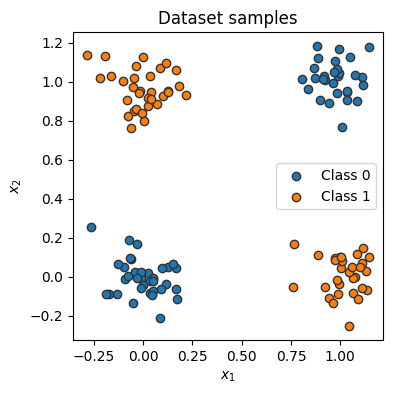

In [6]:
import matplotlib.pyplot as plt

def visualize_samples(data, label):
    data_0 = data[(label == 0).flatten()]
    data_1 = data[(label == 1).flatten()]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

visualize_samples(x, y)

### `Training loop from scratch`

In [196]:
import optax 
from typing import Any,Callable


def get_loss_fn(model:SimpleClassificationModel)->Callable:
    @jax.jit
    def accuracy(logits,y_true):
        y_pred=(logits > 0).astype(jnp.float32)
        return (y_pred==y_true).mean()


    @jax.jit
    def loss_fn(params:dict[str,Any],batch:tuple[jnp.ndarray,jnp.ndarray])->tuple[jax.Array,jax.Array]:
        x,y=batch
        logits=model.apply({'params':params},x) # if u also have batch_stats -> y_pred,update_batch_stats=model.apply({'params':params,'batch_stats':batch_stats},x,mutable=['batch_stats'])
        loss=optax.sigmoid_binary_cross_entropy(logits,y).mean()
        acc=accuracy(logits,y)
        return loss,acc
    
    return loss_fn

def train_step(loss_fn:Callable,batch:tuple[jnp.ndarray,jnp.ndarray],tx:optax.GradientTransformation,opt_state:optax.OptState,variables:dict[str,Any])->tuple[dict[str,Any],optax.OptState,jnp.ndarray]:
     (loss,acc),grads=jax.value_and_grad(loss_fn,has_aux=True)(variables['params'],batch) # if u also have batch_stats -> variables={'params':variables['params'],'batch_stats':variables['batch_stats']}
     updates,opt_state=tx.update(grads,opt_state,variables['params']) 
     variables['params']=optax.apply_updates(variables['params'],updates)
     return variables,opt_state,loss,acc

In [197]:
EPOCHS=30
tx=optax.adamw(learning_rate=0.03)
opt_state=tx.init(variables['params'])
loss_fn=get_loss_fn(model)

history={'train_loss':[],'val_loss':[],'train_accuracy':[],'val_accuracy':[]}

for epoch in range(EPOCHS):
    train_loss,val_loss=0.0,0.0
    train_acc,val_acc=0.0,0.0
    for batch in train_dl:
        variables,opt_state,loss,acc=train_step(loss_fn,batch,tx,opt_state,variables)
        train_loss+=loss
        train_acc+=acc
    train_loss/=len(train_dl)
    train_acc/=len(train_dl)

    for batch in val_dl:
        loss,acc=loss_fn(variables['params'],batch)
        val_loss+=loss
        val_acc+=acc
    val_loss/=len(val_dl)
    val_acc/=len(val_dl)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)

    if (epoch+1)%3==0:
        print(f"Epoch:{epoch+1} Train Loss:{train_loss:.4f} | Train Acc:{train_acc:.4f} | Val Loss:{val_loss:.4f} | Val Acc:{val_acc:.4f}")

Epoch:3 Train Loss:0.3157 | Train Acc:1.0000 | Val Loss:0.3140 | Val Acc:1.0000
Epoch:6 Train Loss:0.3136 | Train Acc:1.0000 | Val Loss:0.3135 | Val Acc:1.0000
Epoch:9 Train Loss:0.3135 | Train Acc:1.0000 | Val Loss:0.3134 | Val Acc:1.0000
Epoch:12 Train Loss:0.3134 | Train Acc:1.0000 | Val Loss:0.3134 | Val Acc:1.0000
Epoch:15 Train Loss:0.3134 | Train Acc:1.0000 | Val Loss:0.3134 | Val Acc:1.0000
Epoch:18 Train Loss:0.3134 | Train Acc:1.0000 | Val Loss:0.3133 | Val Acc:1.0000
Epoch:21 Train Loss:0.3133 | Train Acc:1.0000 | Val Loss:0.3133 | Val Acc:1.0000
Epoch:24 Train Loss:0.3133 | Train Acc:1.0000 | Val Loss:0.3133 | Val Acc:1.0000
Epoch:27 Train Loss:0.3133 | Train Acc:1.0000 | Val Loss:0.3133 | Val Acc:1.0000
Epoch:30 Train Loss:0.3133 | Train Acc:1.0000 | Val Loss:0.3133 | Val Acc:1.0000


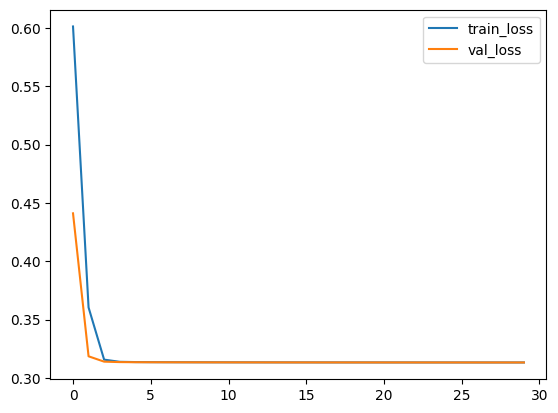

In [198]:
plt.plot(history['train_loss'],label='train_loss')
plt.plot(history['val_loss'],label='val_loss')
plt.legend()

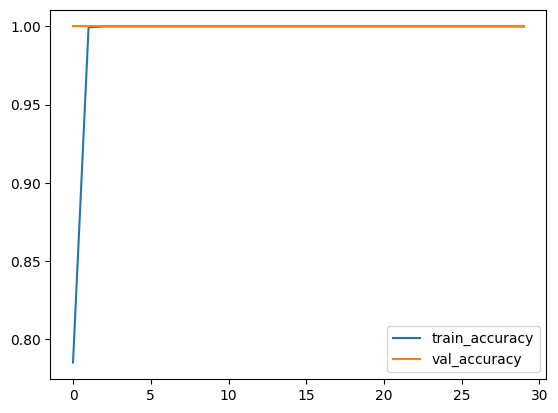

In [199]:
plt.plot(history['train_accuracy'],label='train_accuracy')
plt.plot(history['val_accuracy'],label='val_accuracy')
plt.legend()

### `TrainState to simplify the training loop:`

In [25]:
import jax
import jax.numpy as jnp

import flax 
from flax import linen as nn
from flax.training import train_state

import numpy as np
import matplotlib.pyplot as plt

import optax
from typing import Any,Callable


model=SimpleClassificationModel([10,10,1],activation=nn.tanh)
print(f"Model:{model}")


variables=model.init(jax.random.PRNGKey(0),x)
print(f"Variables:{variables.keys()}")

# A Trainstate in Flax is a simple container for the parameters, state, and optimizer of a model.
# It also provides a few convenience methods for updating the parameters and state, and for applying the model to inputs.
# This can make the training loop a bit simpler and more concise.
model_state=train_state.TrainState.create(
    apply_fn=model.apply,
    params=variables['params'], # parameters over which we want to optimize
    tx=optax.adamw(learning_rate=0.1)
)

from typing import Any,Callable

def get_loss_fn()->Callable:
    @jax.jit
    def accuracy(logits,y):
        preds=(logits>0.).astype(jnp.float32)
        return jnp.mean(preds==y)
    
    @jax.jit
    def calc_acc_and_loss(params:dict[str,Any],state:train_state.TrainState,batch:tuple[np.ndarray,np.ndarray])->tuple[jnp.ndarray,jnp.ndarray]:

        x,y=batch
        logits=state.apply_fn({'params':params},x) # apply_fn is the model's forward pass
        loss=jnp.mean(optax.sigmoid_binary_cross_entropy(logits,y))
        acc=accuracy(logits,y)
        return loss,acc
    return calc_acc_and_loss


def train_step(loss_fn:Callable,state:train_state.TrainState,batch:tuple[np.ndarray,np.ndarray]):
    (loss,acc),grads=jax.value_and_grad(loss_fn,has_aux=True)(state.params,state,batch)
    model_state=state.apply_gradients(grads=grads) # apply_gradients updates the parameters and state of the model
    return loss,acc,model_state


Model:SimpleClassificationModel(
    # attributes
    feature_sizes = [10, 10, 1]
    activation = tanh
    kernel_init = init
    bias_init = zeros
)
Variables:dict_keys(['params'])


In [26]:
EPOCHS=30
history={'train_loss':[],'val_loss':[],'train_accuracy':[],'val_accuracy':[]}

loss_fn=get_loss_fn()
for epoch in range(EPOCHS):
    train_loss,val_loss=0.0,0.0
    train_acc,val_acc=0.0,0.0
    for batch in train_dl:
        loss,acc,model_state=train_step(loss_fn,model_state,batch)
        train_loss+=loss
        train_acc+=acc
    train_loss/=len(train_dl)
    train_acc/=len(train_dl)

    for batch in val_dl:
        loss,acc=loss_fn(model_state.params,model_state,batch)
        val_loss+=loss
        val_acc+=acc
    val_loss/=len(val_dl)
    val_acc/=len(val_dl)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)

    if (epoch+1)%3==0:
        print(f"Epoch:{epoch+1} Train Loss:{train_loss:.4f} | Train Acc:{train_acc:.4f} | Val Loss:{val_loss:.4f} | Val Acc:{val_acc:.4f}")

Epoch:3 Train Loss:0.3133 | Train Acc:1.0000 | Val Loss:0.3133 | Val Acc:1.0000
Epoch:6 Train Loss:0.3133 | Train Acc:1.0000 | Val Loss:0.3133 | Val Acc:1.0000
Epoch:9 Train Loss:0.3133 | Train Acc:1.0000 | Val Loss:0.3133 | Val Acc:1.0000
Epoch:12 Train Loss:0.3133 | Train Acc:1.0000 | Val Loss:0.3133 | Val Acc:1.0000
Epoch:15 Train Loss:0.3133 | Train Acc:1.0000 | Val Loss:0.3133 | Val Acc:1.0000
Epoch:18 Train Loss:0.3133 | Train Acc:1.0000 | Val Loss:0.3133 | Val Acc:1.0000
Epoch:21 Train Loss:0.3133 | Train Acc:1.0000 | Val Loss:0.3133 | Val Acc:1.0000
Epoch:24 Train Loss:0.3133 | Train Acc:1.0000 | Val Loss:0.3133 | Val Acc:1.0000
Epoch:27 Train Loss:0.3133 | Train Acc:1.0000 | Val Loss:0.3133 | Val Acc:1.0000
Epoch:30 Train Loss:0.3133 | Train Acc:1.0000 | Val Loss:0.3133 | Val Acc:1.0000


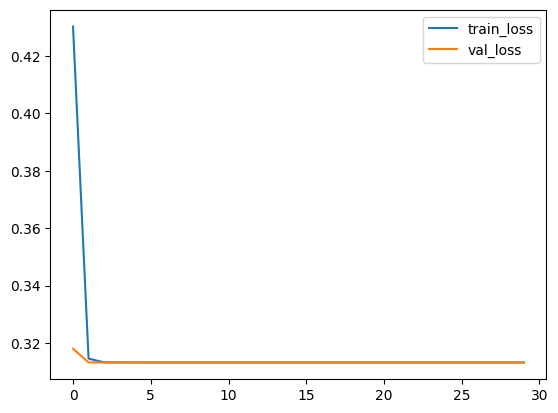

In [27]:
plt.plot(history['train_loss'],label='train_loss')
plt.plot(history['val_loss'],label='val_loss')
plt.legend()



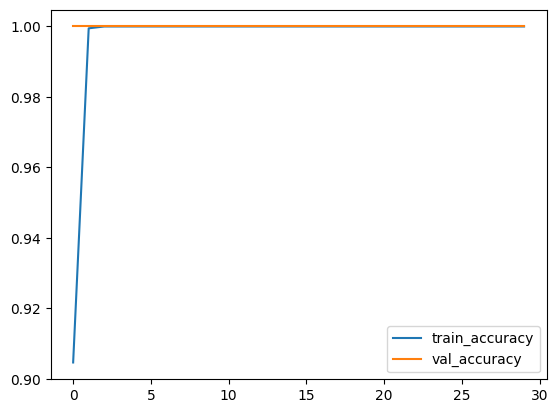

In [28]:
plt.plot(history['train_accuracy'],label='train_accuracy')
plt.plot(history['val_accuracy'],label='val_accuracy')
plt.legend()

### `Saving and Loading Models`

In [35]:
# To save and load models in Flax, we can use the flax.serialization.to_bytes() and flax.serialization.from_bytes() functions, or flax.serialization.to_state_dict() and flax.serialization.from_state_dict()

# Or we can use checkpoint.save() and checkpoint.restore() to save and restore the model state.

from flax.training import checkpoints
import os

checkpoints.save_checkpoint(ckpt_dir=f"{os.getcwd()}/checkpoints",target=model_state,prefix="ckpt-",step=30,overwrite=True)

# To load the model state, we can use the checkpoint.restore() function.
# model_state=checkpoints.restore_checkpoint(ckpt_dir="./checkpoints",target=model_state,prefix="ckpt-",step=30)

'd:\\Deep Learning From Scratch\\JAX\\checkpoints\\ckpt-30'

In [42]:
# After training one can bind the model to the parameters , so that we can infer without need to explicitly call apply_fn

model=model.bind({'params':model_state.params})

for batch in val_dl:
    x,y=batch
    logits=model(x)
    loss=jnp.mean(optax.sigmoid_binary_cross_entropy(logits,y))
    acc=jnp.mean((logits>0.).astype(jnp.float32)==y)
    print(f"Val Loss:{loss:.4f} | Val Acc:{acc:.4f}")
    break

Val Loss:0.3133 | Val Acc:1.0000
